In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_relative_footsteps_acc_absolute
%store -r Y_relative_footsteps_acc_absolute
print(X_relative_footsteps_acc_absolute.shape)
print(Y_relative_footsteps_acc_absolute.shape)

(4250, 28)
(4250, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_relative_footsteps_acc_absolute[:, 21] == 1)[0]
X_relative_footsteps_acc_absolute_RR_swing = X_relative_footsteps_acc_absolute[idxs]
Y_relative_footsteps_acc_absolute_RR_swing = Y_relative_footsteps_acc_absolute[idxs]

## Predict FL foot -> x

In [8]:
X_relative_footsteps_acc_absolute_RR_swing[0, :]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.55230072e-03,
       -5.57333773e-02,  2.00843323e-02,  5.70501929e-02,  2.51797872e-02,
       -5.53277449e-03,  2.39038799e-01,  1.84310655e-01, -4.30978244e-01,
        2.30758733e-01, -1.72486945e-01, -4.32495792e-01, -2.49158602e-01,
        1.64481703e-01, -4.30547602e-01, -2.46053101e-01, -1.48265926e-01,
       -4.30288818e-01,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  8.56913844e+01,  8.56904766e+01])

In [9]:
Y_relative_footsteps_acc_absolute_RR_swing[0, :]

array([-0.00592088, -0.00118174, -0.00278665, -0.00589627])

### Linear Regression

In [11]:
# Input
X = np.hstack((X_relative_footsteps_acc_absolute_RR_swing[:, :3], # prev velocity command
               X_relative_footsteps_acc_absolute_RR_swing[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_absolute_RR_swing[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_absolute_RR_swing[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_absolute_RR_swing[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_absolute_RR_swing[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_absolute_RR_swing[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_x = LinearRegression()

# Fit the model
model_rr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9749868361292864
RMSE:  0.005730132493496204
The lowest error is:  8.349828311243757e-06
The highest error is:  0.0336020867804285
The avg. error is:  0.003230866835184605


In [12]:
model_rr_relative_swinging_x.coef_

array([[-1.38207629e-03, -5.97547185e-15, -4.44089210e-16,
         0.00000000e+00, -1.73892683e+00,  1.73894196e+00,
        -2.76752210e-01, -2.33167327e-01,  1.55256189e-01,
         5.71621885e-01, -2.90798681e-01,  1.95093633e-01,
        -6.60873338e-01,  2.25068217e-01]])

In [13]:
model_rr_relative_swinging_x.intercept_

array([-0.0625494])

Text(0, 0.5, 'Predictions')

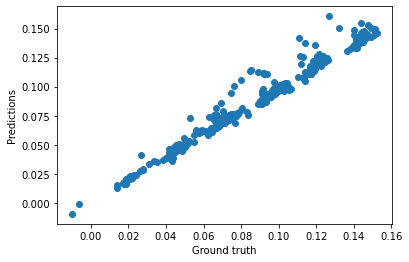

In [14]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [15]:
#%store model_rr_relative_swinging_x

In [16]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [17]:
# Save model
#joblib.dump(model_rr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_x.sav")

### Predict RR foot -> y

In [19]:
# Input
X = np.hstack((X_relative_footsteps_acc_absolute_RR_swing[:, :3], # prev velocity command
               X_relative_footsteps_acc_absolute_RR_swing[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_absolute_RR_swing[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_absolute_RR_swing[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_absolute_RR_swing[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_absolute_RR_swing[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_absolute_RR_swing[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_y = LinearRegression()

# Fit the model
model_rr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.7958140359822424
RMSE:  0.0017432185067947613
The lowest error is:  4.422846850399287e-06
The highest error is:  0.014320684723207883
The avg. error is:  0.000914110632348441


In [20]:
model_rr_relative_swinging_y.coef_

array([[ 3.05808888e-03, -5.38721086e-15,  8.32667268e-17,
        -3.05311332e-16, -2.24867596e-01,  2.24868218e-01,
         1.95600835e-01,  4.78025385e-01, -1.55831137e-01,
         3.09265009e-01, -7.54178983e-02, -7.33077773e-02,
        -1.54879851e-01, -7.02146926e-01]])

In [21]:
model_rr_relative_swinging_y.intercept_

array([-0.20060715])

Text(0, 0.5, 'Predictions')

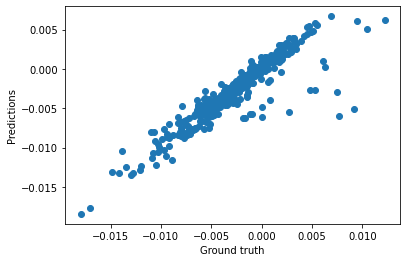

In [22]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#%store model_rr_relative_swinging_y

In [30]:
#for idx, prediction in enumerate(predictions):
#    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [31]:
# Save model
#joblib.dump(model_rr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_y.sav")